In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
root = '/kaggle/input/hms-harmful-brain-activity-classification/'

EEG_PATH = root+'train_eegs/'
SPEC_PATH = root+'train_spectrograms/'

train = pd.read_csv(root+'train.csv')
print(train[train.expert_consensus=="LPD"].head(100))
def read_praq(row_num,data = train, eeg = True):
    GET_ROW = row_num
    row = train.iloc[GET_ROW]
    if eeg:
        eeg = pd.read_parquet(f'{EEG_PATH}{row.eeg_id}.parquet')
        eeg_offset = int( row.eeg_label_offset_seconds )
        eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]
        return eeg
    else:
        spectrogram = pd.read_parquet(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
        spec_offset = int(row.spectrogram_label_offset_seconds )
        spectrogram = spectrogram.loc[(spectrogram.time>=spec_offset)
                             &(spectrogram.time<spec_offset+600)]
        return spectrogram
eeg = read_praq(5)

          eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
277    736446371           0                       0.0        10397461   
278    688312769           0                       0.0        10397461   
279   1768958569           0                       0.0        10397461   
280   1768958569           1                       4.0        10397461   
281   1041252567           0                       0.0        10397461   
...          ...         ...                       ...             ...   
1659  1459709537           1                      26.0        19384736   
1660  1459709537           2                      42.0        19384736   
1661  1459709537           3                      86.0        19384736   
1662  1459709537           4                      92.0        19384736   
1663  1387527015           0                       0.0        19384736   

      spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
277                    0             

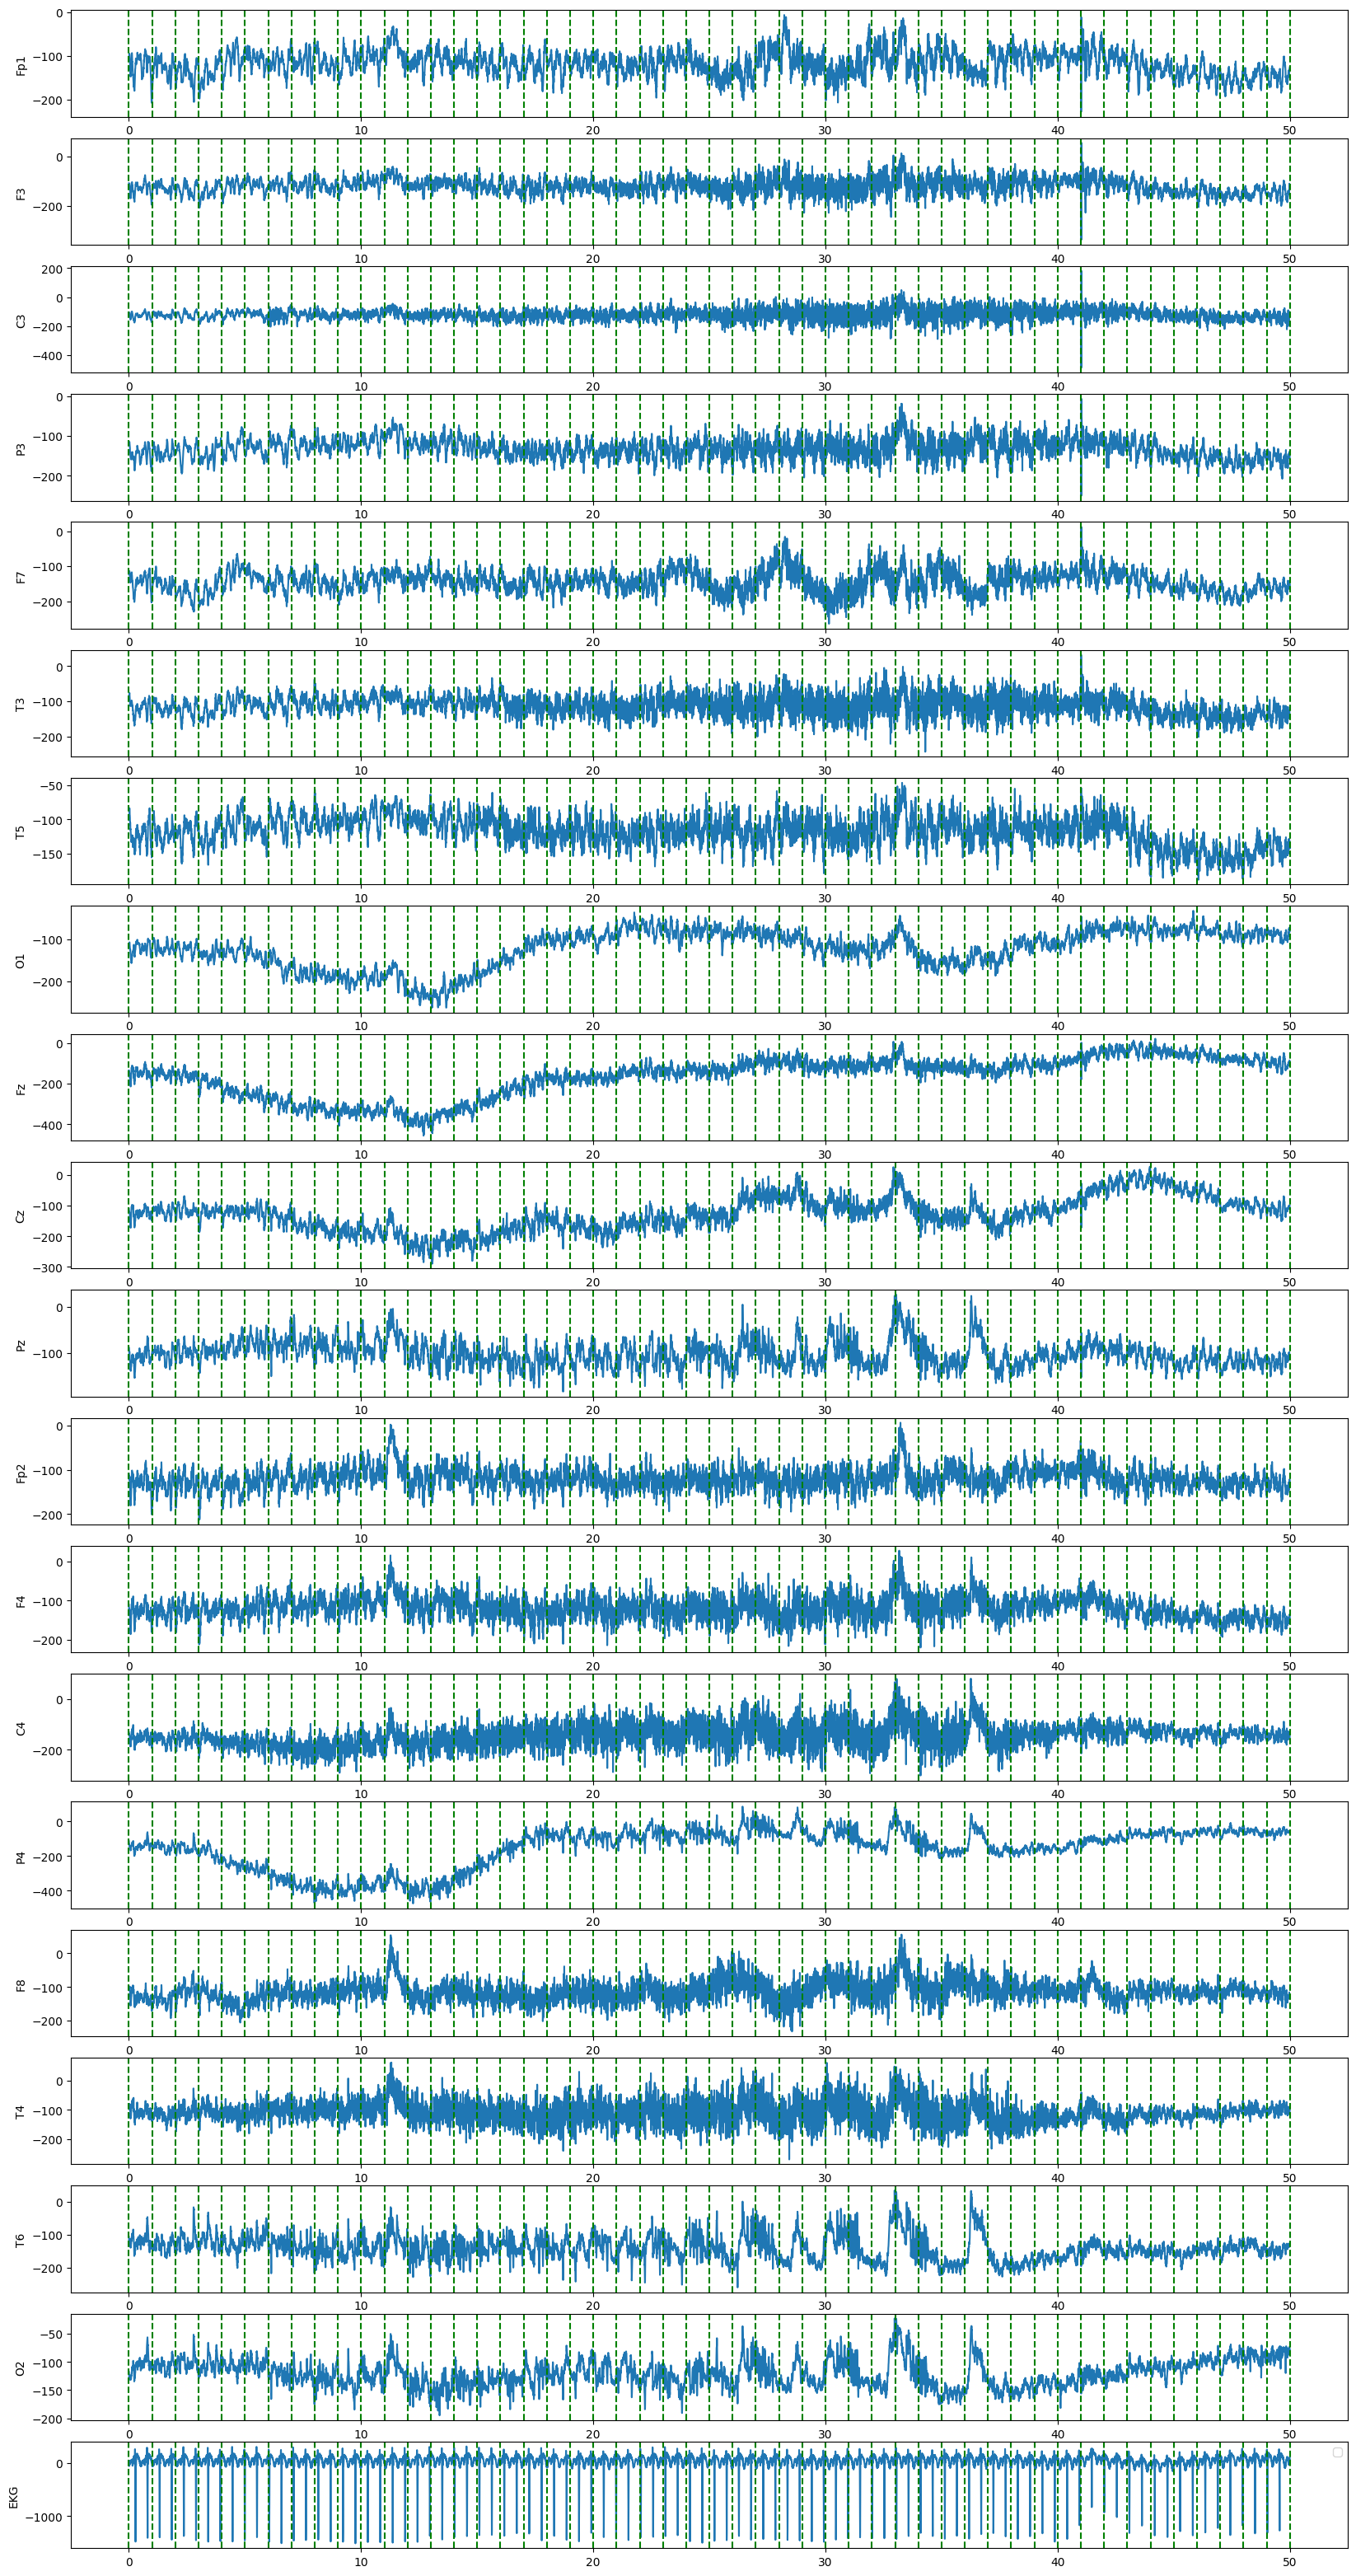

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_eeg(eeg,start=0,end=50):
    fig, ax = plt.subplots(nrows = len(eeg.columns), ncols = 1, figsize = (20,40))
    for i,columns in enumerate(eeg.columns):
        sns.lineplot(x = (eeg.index[start*200:end*200]-eeg.index[0])/200, y = eeg[columns][start*200:end*200],ax = ax[i])
        for j in range(start,end+1):
            ax[i].axvline(x = j, color='green', linestyle='--')
    plt.legend()
    plt.show()
plot_eeg(eeg)

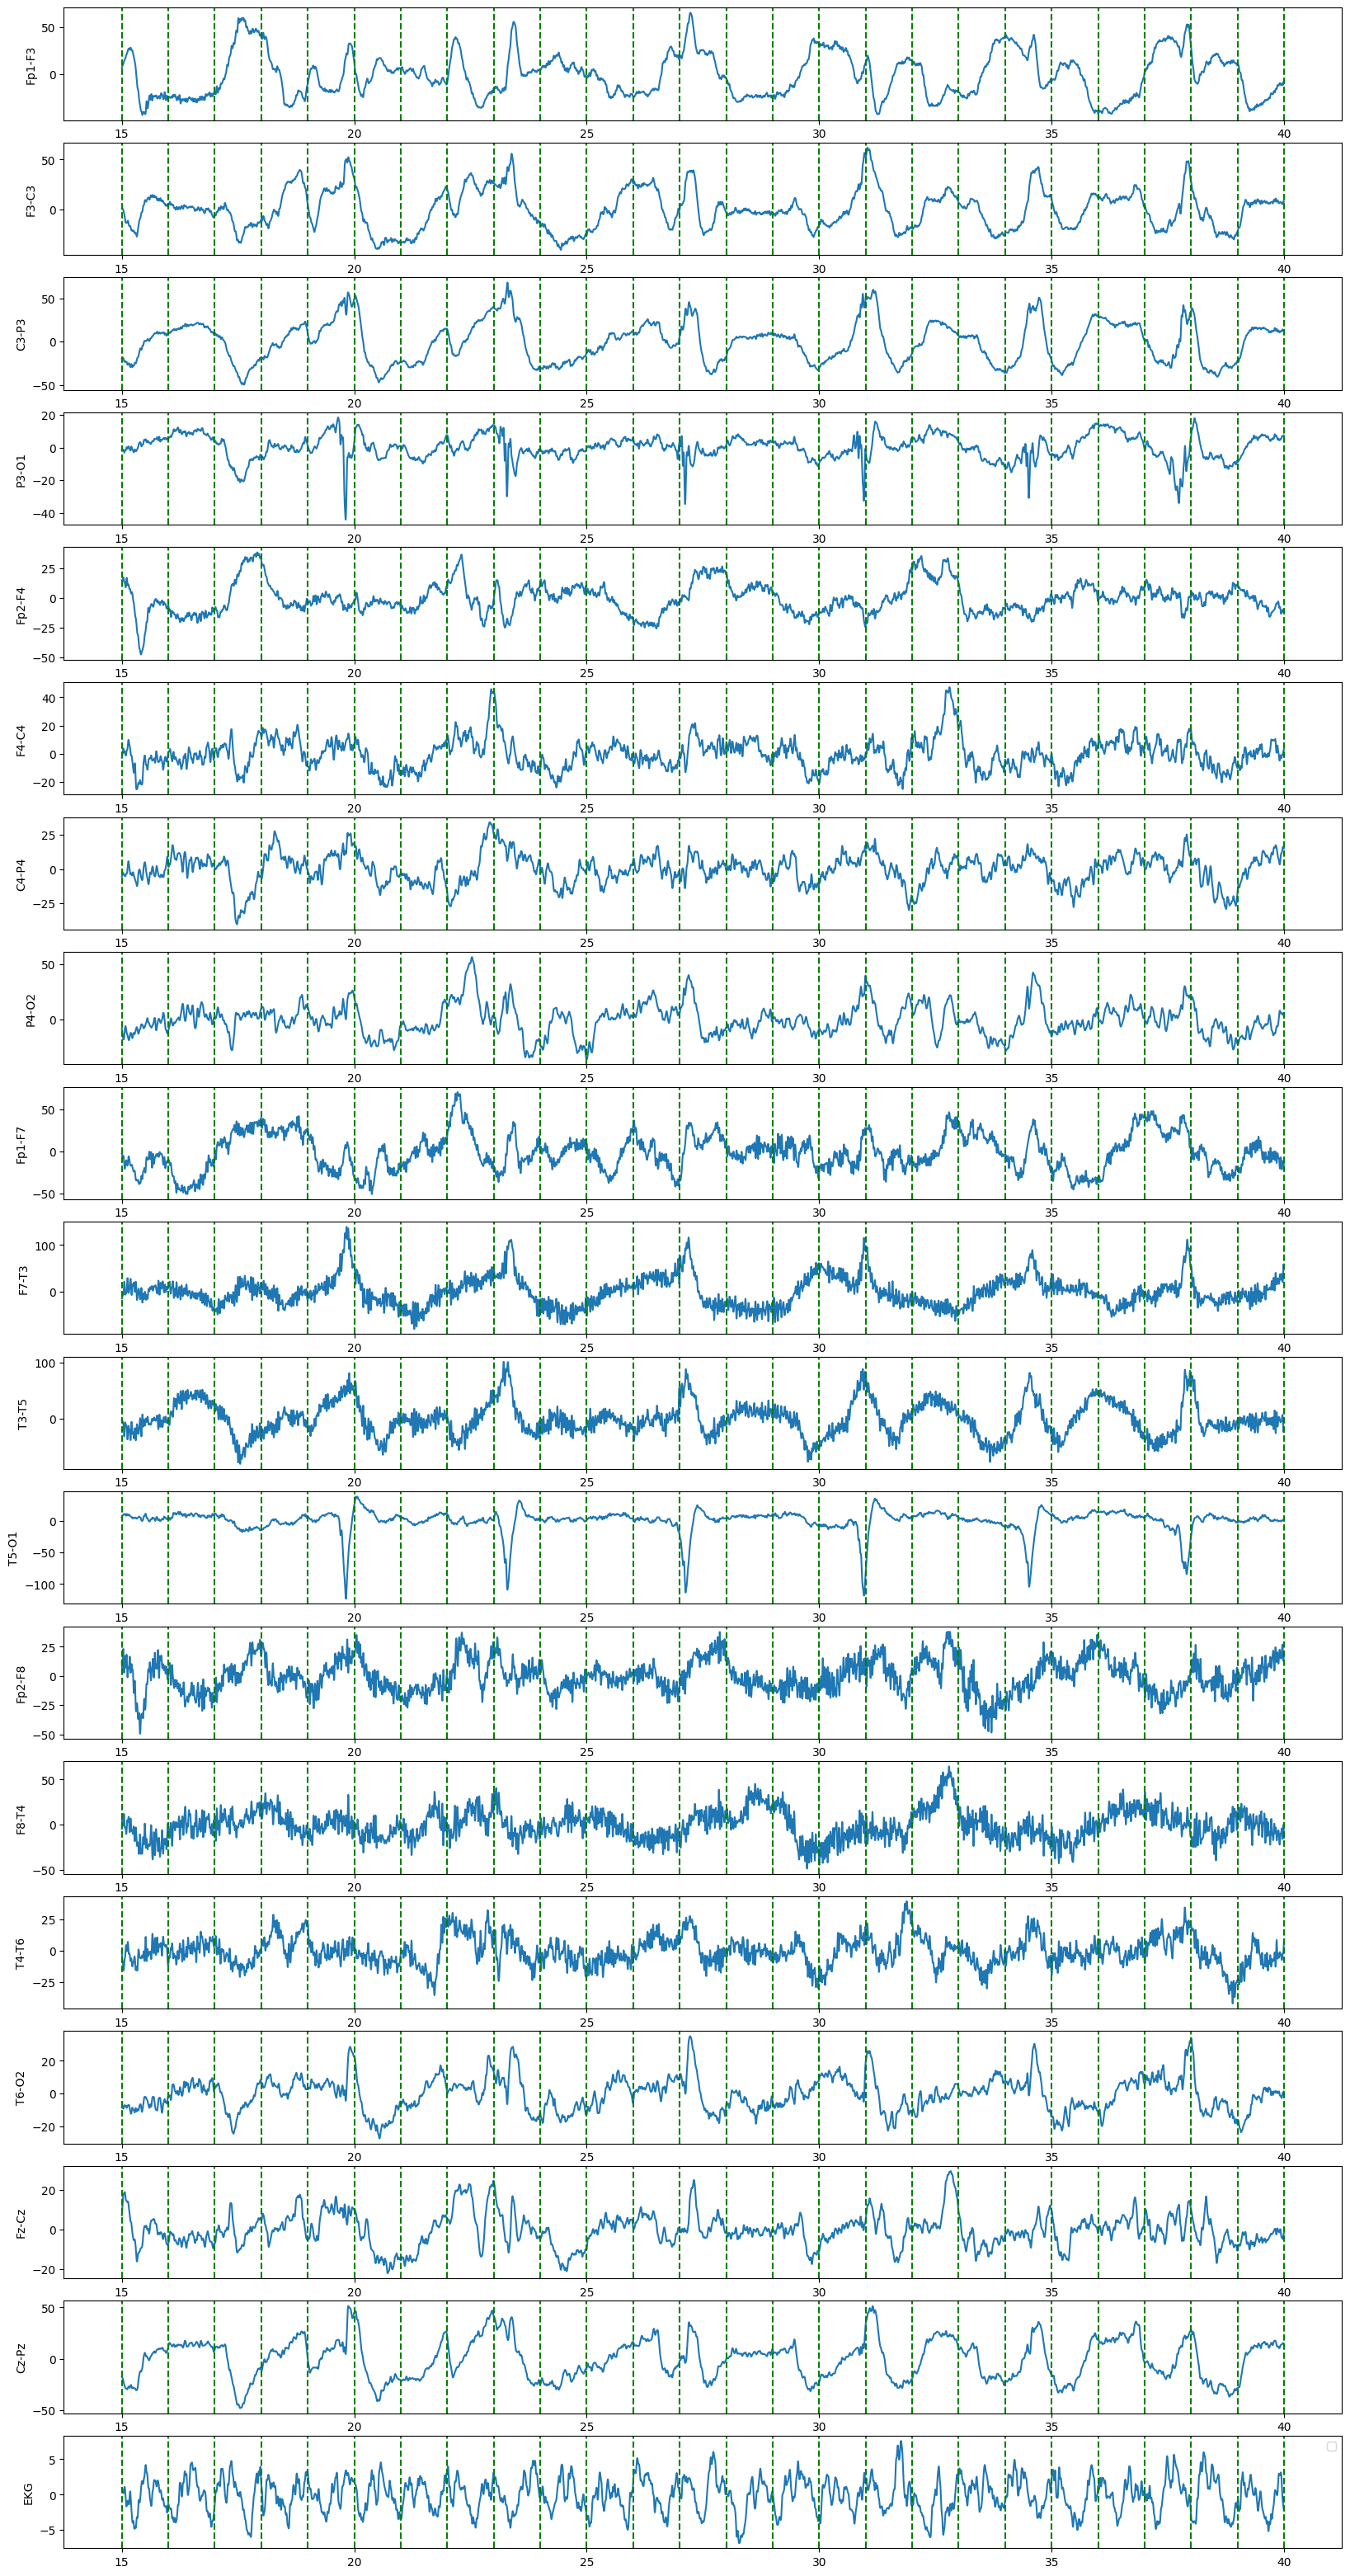

In [9]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft, fftfreq

def trfm_eeg(eeg):
    teeg = pd.DataFrame()
    teeg['Fp1-F3'] = eeg.Fp1-eeg.F3
    teeg['F3-C3'] = eeg.F3-eeg.C3
    teeg['C3-P3'] = eeg.C3-eeg.P3
    teeg['P3-O1'] = eeg.P3-eeg.O1
    
    teeg['Fp2-F4'] = eeg.Fp2-eeg.F4
    teeg['F4-C4'] = eeg.F4-eeg.C4
    teeg['C4-P4'] = eeg.C4-eeg.P4
    teeg['P4-O2'] = eeg.P4-eeg.O2
    
    teeg['Fp1-F7'] = eeg.Fp1-eeg.F7
    teeg['F7-T3'] = eeg.F7-eeg.T3
    teeg['T3-T5'] = eeg.T3-eeg.T5
    teeg['T5-O1'] = eeg.T5-eeg.O1
    
    teeg['Fp2-F8'] = eeg.Fp2-eeg.F8
    teeg['F8-T4'] = eeg.F8-eeg.T4
    teeg['T4-T6'] = eeg.T4-eeg.T6
    teeg['T6-O2'] = eeg.T6-eeg.O2
    
    teeg['Fz-Cz'] = eeg.Fz-eeg.Cz
    teeg['Cz-Pz'] = eeg.Cz-eeg.Pz

    
    return teeg


def filter_freq(signal, low, high, sampling_rate=200):
    N = len(signal)

    frequencies = fftfreq(N, d=1/sampling_rate)
    fft_values = fft(signal)

    low_cutoff = low
    high_cutoff = high  

    # Create a mask to zero out frequencies outside the desired range
    mask = (frequencies >= low_cutoff) & (frequencies <= high_cutoff)
    fft_values_filtered = fft_values * mask

    filtered_signal = ifft(fft_values_filtered).real
    return filtered_signal

def filter_eeg(eeg, low=0, high=700):
    eegc = eeg.copy()
    for columns in eegc.columns:
        eegc[columns] = filter_freq(np.array(eegc[columns]),low,high)
    return eegc

def normalize(EEG):
    eeg = EEG.copy()
    for column in eeg.columns:
        mini = eeg[column].min()
        eeg[column] = eeg[column]+mini
        maxi = eeg[column].max()
        eeg[column] = eeg[column]/maxi
        mean = eeg[column].mean()
        eeg[column] = eeg[column]-mean
    return eeg
    
    
        
eeg = read_praq(1660)
eeg = filter_eeg(eeg,0.2,30)
eeg = trfm_eeg(eeg)
plot_eeg(eeg,15,40)


In [1]:
import torch
import torch.nn as nn

class CustomNetwork(nn.Module):
    def __init__(self, input_channels, output_classes, num_channels, num_signals):
        super(CustomNetwork, self).__init__()

        # Create separate convolutional layers for each signal
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(input_channels, num_channels, kernel_size=3),
                nn.ReLU(),
                nn.Conv1d(num_channels, num_channels, kernel_size=7),
                nn.ReLU(),
                nn.Conv1d(num_channels, num_channels, kernel_size=11),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2),
                nn.Conv1d(num_channels, num_channels, kernel_size=5),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=4, stride=4)
            ) for _ in range(num_signals)
        ])

        # Fully connected layers
        self.fc1 = nn.Linear(621 * num_channels  * num_signals, 512)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 6)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Apply convolutional layers for each signal
        signal_outputs = [conv_layer(signal).view(-1) for conv_layer, signal in zip(self.conv_layers, x)]

        # Concatenate the outputs along the channel axis
        x = torch.cat(signal_outputs, dim=0)

        # Reshape for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)

        return x


input_channels = 1  
output_classes = 6 
num_channels = 16  
num_signals = 18

model = CustomNetwork(input_channels, output_classes, num_channels, num_signals)
print(model)


CustomNetwork(
  (conv_layers): ModuleList(
    (0-17): 18 x Sequential(
      (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(16, 16, kernel_size=(11,), stride=(1,))
      (5): ReLU()
      (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv1d(16, 16, kernel_size=(5,), stride=(1,))
      (8): ReLU()
      (9): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc1): Linear(in_features=180000, out_features=512, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=512, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
from torch.utils.data import Dataset

class Signals(Dataset):
    def __init__(self, train_df): 
        self.data =train_df

    def __len__(self):
        return len(self.data.shape[0])

    def __getitem__(self, idx):
        eeg = read_praq(idx,self.data)
        eeg = trfm_eeg(eeg)
        eeg = filter_eeg(eeg,0.2,50)
        eeg = eeg[eeg.index % 2 != 0]
        eeg = normalize(eeg)
        signals = torch.tensor(eeg.values, dtype = torch.float32).t()
        columns_for_probabilities = ['seizure_vote',  'lpd_vote',  'gpd_vote','lrda_vote',  'grda_vote', 'other_vote']

        # Extract the relevant row and columns
        row_to_transform = self.data.loc[idx, columns_for_probabilities]

        # Convert the row to PyTorch tensor
        tensor_row = torch.tensor(row_to_transform.values, dtype=torch.float32)

        # Apply softmax to get probabilities
        probabilities = F.softmax(tensor_row, dim=0)
        
        return signals, probabilities

In [ ]:
from torch.utils.data import DataLoader
batch_size = 64  # Choose an appropriate batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10  # Choose an appropriate number of epochs

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
torch.save(model.state_dict(), '/kaggle/output/model.pth')